In [1]:
from typing import List
import networkx as nx
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch_geometric.utils.convert import from_networkx

from collections import Counter
from sklearn.metrics import f1_score
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCN, global_mean_pool
from tqdm import tqdm
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

from pathlib import Path
import os
from random import shuffle

# custom modules
from models import Generator, Discriminator
from custom_dataset import CustomSequenceDataset
from preprocess_data import read_adfa_data, sequence_to_graph, fetch_graph_data
from utils import get_device, plot_loss_curve, evaluate_gcn_model
from classifiers import GCNModel
from train import train_gan_model
from train import train_gcn_model

# read, preprocess, and fetch the ADFA datasets


In [2]:
data_folder = "ADFA"  # make sure "ADFA" folder in the parent directory of this project's folder [ie., your codes]
current_directory = Path(os.getcwd())
parent_path = current_directory.parent.absolute()
# print(current_directory.parent.absolute())

full_data_folder_path = os.path.join(parent_path, data_folder)

In [58]:
adfa_sub_folders = [
    "Training_Data_Master",
    "Validation_Data_Master",
    "Attack_Data_Master",
]

benign_training_data_path = os.path.join(full_data_folder_path, adfa_sub_folders[0])
benign_validation_data_path = os.path.join(full_data_folder_path, adfa_sub_folders[1])

attack_data_path = os.path.join(full_data_folder_path, adfa_sub_folders[2])


# read the sub folders
benign_train_sequences, benign_train_labels = read_adfa_data(benign_training_data_path)

benign_val_sequences, benign_val_labels = read_adfa_data(benign_validation_data_path)

attack_sequences, attack_labels = read_adfa_data(attack_data_path)

# the attack data are splitted into train and val data using 70% and 30% respectively.

shuffle(
    attack_sequences
)  # shuffle the attack data so that the six attack categories are mixed up in the train and val data

# since, label is the 'same' = 1 for all the attack data, no need to shuffle it.
# split the attack_sequences
n_samples = int(len(attack_sequences) * 0.7)
train_attack_sequences = attack_sequences[:n_samples]
train_attack_labels = attack_labels[:n_samples]

val_attack_sequences = attack_sequences[n_samples:]
val_attack_labels = attack_labels[n_samples:]


# Now, combine the both training data
train_data = benign_train_sequences + train_attack_sequences
train_labels = benign_train_labels + train_attack_labels

# combine the validation data
# n_resample_benign  = int (1.2 * len(val_attack_sequences))
n_resample_benign = int(len(val_attack_sequences))

# shuffle benign_val_sequences
shuffle(benign_val_sequences)
val_data = benign_val_sequences[:n_resample_benign] + val_attack_sequences
val_labels = benign_val_labels[:n_resample_benign] + val_attack_labels

len(train_data), len(train_labels), len(val_data), len(val_labels)

(2717, 2717, 902, 902)

In [59]:
len(attack_sequences)

1502

In [60]:
# Data is imbalanced: 1666 samples of benign & 1051 samples of attack (malignant) will be used for training the GCN model
Counter(train_labels)

Counter({0: 1666, 1: 1051})

In [61]:
Counter(val_labels)

Counter({0: 451, 1: 451})

In [62]:
# Create a custom dataset
batch_size = 64
# convert train_data sequences and val_data sequences into graphs

train_graph_dataset = fetch_graph_data(train_data, train_labels)
val_graph_dataset = fetch_graph_data(val_data, val_labels)


# Create a data loader
graph_train_loader = DataLoader(
    train_graph_dataset, batch_size=batch_size, shuffle=True
)
graph_val_loader = DataLoader(val_graph_dataset, batch_size=batch_size, shuffle=False)

In [63]:
# you can see the graph data: it has edge_index, weight, num_nodes, y (label of the graph, i.e., malign or benign), and x (node features). Here, x is a list of integers representing the node features. They need to be converted to a one-hot vector of size vocab_size or vector of embedded representation.
train_graph_dataset[0]

Data(edge_index=[2, 53], weight=[53], num_nodes=26, x=[1], y=0)

In [80]:
# device = get_device()
vocab_size = 342
hidden_dim = 128  # also the number of hidden nodes in the GCN. Can be set to 128, 256 or 512. If you have more GPU, you can increase it. However, you may face overfitting. Increase dropout if you face overfitting. Like dropout = 0.6, 0.7, 0.8
num_classes = 2
dropout = 0.4
output_dim = num_classes
# number of GCN layers, depending on your GPU, set it to any integer from 2 to 5.
num_layers = 3
EPOCHS_GCN = 35


device = torch.device("cpu")


gcn_model = GCNModel(
    in_channels=vocab_size,
    hidden_channels=hidden_dim,
    out_channels=num_classes,
    num_layers=num_layers,
    dropout=dropout,
).to(device)

train_losses, train_f1_scores = train_gcn_model(
    gcn_model,
    graph_train_loader,
    vocab_size=vocab_size,
    epochs=EPOCHS_GCN,
    device=device,
)

100%|██████████| 43/43 [00:00<00:00, 55.48it/s]


Epoch 1 / 35, Loss: 0.5689, F1 Score: 0.4310


100%|██████████| 43/43 [00:00<00:00, 54.79it/s]


Epoch 2 / 35, Loss: 0.4126, F1 Score: 0.8688


100%|██████████| 43/43 [00:00<00:00, 56.33it/s]


Epoch 3 / 35, Loss: 0.3933, F1 Score: 0.8886


100%|██████████| 43/43 [00:00<00:00, 57.54it/s]


Epoch 4 / 35, Loss: 0.3828, F1 Score: 0.9075


100%|██████████| 43/43 [00:00<00:00, 57.37it/s]


Epoch 5 / 35, Loss: 0.3714, F1 Score: 0.9220


100%|██████████| 43/43 [00:00<00:00, 55.27it/s]


Epoch 6 / 35, Loss: 0.3646, F1 Score: 0.9327


100%|██████████| 43/43 [00:00<00:00, 58.96it/s]


Epoch 7 / 35, Loss: 0.3591, F1 Score: 0.9390


100%|██████████| 43/43 [00:00<00:00, 52.65it/s]


Epoch 8 / 35, Loss: 0.3525, F1 Score: 0.9476


100%|██████████| 43/43 [00:00<00:00, 56.00it/s]


Epoch 9 / 35, Loss: 0.3549, F1 Score: 0.9487


100%|██████████| 43/43 [00:00<00:00, 59.01it/s]


Epoch 10 / 35, Loss: 0.3552, F1 Score: 0.9435


100%|██████████| 43/43 [00:00<00:00, 59.17it/s]


Epoch 11 / 35, Loss: 0.3505, F1 Score: 0.9505


100%|██████████| 43/43 [00:00<00:00, 59.60it/s]


Epoch 12 / 35, Loss: 0.3491, F1 Score: 0.9507


100%|██████████| 43/43 [00:00<00:00, 60.94it/s]


Epoch 13 / 35, Loss: 0.3478, F1 Score: 0.9543


100%|██████████| 43/43 [00:00<00:00, 59.04it/s]


Epoch 14 / 35, Loss: 0.3450, F1 Score: 0.9604


100%|██████████| 43/43 [00:00<00:00, 58.78it/s]


Epoch 15 / 35, Loss: 0.3423, F1 Score: 0.9641


100%|██████████| 43/43 [00:00<00:00, 60.36it/s]


Epoch 16 / 35, Loss: 0.3480, F1 Score: 0.9559


100%|██████████| 43/43 [00:00<00:00, 59.02it/s]


Epoch 17 / 35, Loss: 0.3460, F1 Score: 0.9592


100%|██████████| 43/43 [00:00<00:00, 53.00it/s]


Epoch 18 / 35, Loss: 0.3424, F1 Score: 0.9631


100%|██████████| 43/43 [00:00<00:00, 53.63it/s]


Epoch 19 / 35, Loss: 0.3431, F1 Score: 0.9607


100%|██████████| 43/43 [00:00<00:00, 56.48it/s]


Epoch 20 / 35, Loss: 0.3465, F1 Score: 0.9542


100%|██████████| 43/43 [00:00<00:00, 58.05it/s]


Epoch 21 / 35, Loss: 0.3421, F1 Score: 0.9666


100%|██████████| 43/43 [00:00<00:00, 57.16it/s]


Epoch 22 / 35, Loss: 0.3443, F1 Score: 0.9588


100%|██████████| 43/43 [00:00<00:00, 59.30it/s]


Epoch 23 / 35, Loss: 0.3414, F1 Score: 0.9622


100%|██████████| 43/43 [00:00<00:00, 57.22it/s]


Epoch 24 / 35, Loss: 0.3422, F1 Score: 0.9628


100%|██████████| 43/43 [00:00<00:00, 57.30it/s]


Epoch 25 / 35, Loss: 0.3413, F1 Score: 0.9643


100%|██████████| 43/43 [00:00<00:00, 58.97it/s]


Epoch 26 / 35, Loss: 0.3382, F1 Score: 0.9688


100%|██████████| 43/43 [00:00<00:00, 59.92it/s]


Epoch 27 / 35, Loss: 0.3375, F1 Score: 0.9705


100%|██████████| 43/43 [00:00<00:00, 54.58it/s]


Epoch 28 / 35, Loss: 0.3372, F1 Score: 0.9696


100%|██████████| 43/43 [00:00<00:00, 53.47it/s]


Epoch 29 / 35, Loss: 0.3350, F1 Score: 0.9756


100%|██████████| 43/43 [00:00<00:00, 58.46it/s]


Epoch 30 / 35, Loss: 0.3399, F1 Score: 0.9651


100%|██████████| 43/43 [00:00<00:00, 60.21it/s]


Epoch 31 / 35, Loss: 0.3376, F1 Score: 0.9717


100%|██████████| 43/43 [00:00<00:00, 61.74it/s]


Epoch 32 / 35, Loss: 0.3380, F1 Score: 0.9713


100%|██████████| 43/43 [00:00<00:00, 60.82it/s]


Epoch 33 / 35, Loss: 0.3340, F1 Score: 0.9775


100%|██████████| 43/43 [00:00<00:00, 59.57it/s]


Epoch 34 / 35, Loss: 0.3358, F1 Score: 0.9732


100%|██████████| 43/43 [00:00<00:00, 59.23it/s]

Epoch 35 / 35, Loss: 0.3360, F1 Score: 0.9725


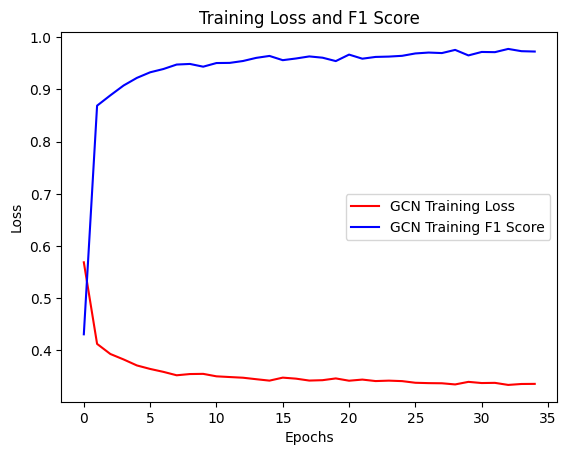

In [81]:
x = np.arange(EPOCHS_GCN, dtype=int)
plt.plot(x, train_losses, color="red", label="GCN Training Loss")
plt.plot(x, train_f1_scores, color="blue", label="GCN Training F1 Score")
plt.title("Training Loss and F1 Score")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [82]:
evaluate_gcn_model(gcn_model, graph_val_loader, vocab_size=vocab_size, device=device)

GCN performance:
Accuracy: 0.9213
Precision: 0.8846
Recall: 0.9690
F1 score: 0.9249
MCC: 0.8464


In [83]:
# PREPARE DATASET FOR GAN MODEL: pad the sequences to make them of same length, then trim them to a fixed sequence length to avoid too much padding.
# convert train_data sequences and val_data sequences into graphs
SEQUENCE_LENGTH = 100
train_data_padded = pad_sequence(
    [torch.tensor(sequence, dtype=torch.long) for sequence in train_data],
    batch_first=True,
)
val_data_padded = pad_sequence(
    [torch.tensor(sequence, dtype=torch.long) for sequence in val_data],
    batch_first=True,
)

train_data_padded.shape, val_data_padded.shape

(torch.Size([2717, 2948]), torch.Size([902, 3158]))

In [12]:
train_data_padded[:, SEQUENCE_LENGTH].shape, val_data_padded[:SEQUENCE_LENGTH].shape

# our dataset will be of shape (n_samples, SEQUENCE_LENGTH).
train_dataset = CustomSequenceDataset(
    train_data_padded[:, :SEQUENCE_LENGTH], train_labels
)
val_dataset = CustomSequenceDataset(val_data_padded[:, :SEQUENCE_LENGTH], val_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [13]:
# hyperparameters of the generator and discriminator of the GAN model
latent_dim = 100
hidden_dim = 128
vocab_size = 342  # we have 342 unique system calls in the ADFA dataset
seq_len = SEQUENCE_LENGTH  # sequence length of the ADFA dataset with less than 120, will be padded. If sequence is longer than 120, it will be truncated.
output_dim = vocab_size
embed_dim = 10
dropout = 0.5
batch_size = 32
n_samples = 1000
num_classes = 2
lr = 1e-4  # 2e-6
epochs = 50
# criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()
device = get_device()
temperature = 0.2  # 0.1

gen = Generator(
    latent_dim,
    seq_len,
    hidden_dim,
    output_dim,
    embed_dim,
    dropout,
    conditional_info=True,
    num_classes=num_classes,
).to(device)
# gen = Gen(latent_dim, hidden_dim, seq_len, output_dim, embed_dim, dropout).to(device)

disc = Discriminator(
    vocab_size,
    seq_len,
    hidden_dim,
    embed_dim,
    dropout,
    conditional_info=True,
    num_classes=num_classes,
).to(device)

gen_optimizer = Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))

disc_optimizer = Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))

In [14]:
# input_data = torch.randint(0, vocab_size, (n_samples, seq_len))
# input_labels = torch.randint(0, num_classes, (n_samples,))
# train_dataset = CustomSequenceDataset(input_data, input_labels)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [15]:
# note that the temperature is set to any value between 0 and 1.
g_losses, d_losses = train_gan_model(
    gen,
    disc,
    gen_optimizer,
    disc_optimizer,
    train_loader,
    epochs,
    vocab_size,
    device=device,
    tau=temperature,
)

Epoch 1 / 50


100%|██████████| 43/43 [00:03<00:00, 11.36it/s]


D Loss: 1.3847, G Loss: -0.6847
Epoch 2 / 50


100%|██████████| 43/43 [00:02<00:00, 20.46it/s]


D Loss: 1.3890, G Loss: -0.6878
Epoch 3 / 50


100%|██████████| 43/43 [00:02<00:00, 20.51it/s]


D Loss: 1.3889, G Loss: -0.6920
Epoch 4 / 50


100%|██████████| 43/43 [00:02<00:00, 20.45it/s]


D Loss: 1.3817, G Loss: -0.6934
Epoch 5 / 50


100%|██████████| 43/43 [00:02<00:00, 20.52it/s]


D Loss: 1.3899, G Loss: -0.6913
Epoch 6 / 50


100%|██████████| 43/43 [00:02<00:00, 20.50it/s]


D Loss: 1.3847, G Loss: -0.6924
Epoch 7 / 50


100%|██████████| 43/43 [00:02<00:00, 20.43it/s]


D Loss: 1.3851, G Loss: -0.6946
Epoch 8 / 50


100%|██████████| 43/43 [00:02<00:00, 20.47it/s]


D Loss: 1.3834, G Loss: -0.6973
Epoch 9 / 50


100%|██████████| 43/43 [00:02<00:00, 19.74it/s]


D Loss: 1.3818, G Loss: -0.6942
Epoch 10 / 50


100%|██████████| 43/43 [00:02<00:00, 20.41it/s]


D Loss: 1.3879, G Loss: -0.6973
Epoch 11 / 50


100%|██████████| 43/43 [00:02<00:00, 20.27it/s]


D Loss: 1.3804, G Loss: -0.6949
Epoch 12 / 50


100%|██████████| 43/43 [00:02<00:00, 20.46it/s]


D Loss: 1.3813, G Loss: -0.6916
Epoch 13 / 50


100%|██████████| 43/43 [00:02<00:00, 20.47it/s]


D Loss: 1.3858, G Loss: -0.6895
Epoch 14 / 50


100%|██████████| 43/43 [00:02<00:00, 20.46it/s]


D Loss: 1.3829, G Loss: -0.6925
Epoch 15 / 50


100%|██████████| 43/43 [00:02<00:00, 20.46it/s]


D Loss: 1.3829, G Loss: -0.6907
Epoch 16 / 50


100%|██████████| 43/43 [00:02<00:00, 20.47it/s]


D Loss: 1.3827, G Loss: -0.6949
Epoch 17 / 50


100%|██████████| 43/43 [00:02<00:00, 20.49it/s]


D Loss: 1.3828, G Loss: -0.6947
Epoch 18 / 50


100%|██████████| 43/43 [00:02<00:00, 20.50it/s]


D Loss: 1.3861, G Loss: -0.6946
Epoch 19 / 50


100%|██████████| 43/43 [00:02<00:00, 20.52it/s]


D Loss: 1.3899, G Loss: -0.6935
Epoch 20 / 50


100%|██████████| 43/43 [00:02<00:00, 20.53it/s]


D Loss: 1.3899, G Loss: -0.6936
Epoch 21 / 50


100%|██████████| 43/43 [00:02<00:00, 20.46it/s]


D Loss: 1.3836, G Loss: -0.6941
Epoch 22 / 50


100%|██████████| 43/43 [00:02<00:00, 19.92it/s]


D Loss: 1.3920, G Loss: -0.6941
Epoch 23 / 50


100%|██████████| 43/43 [00:02<00:00, 20.23it/s]


D Loss: 1.3850, G Loss: -0.6896
Epoch 24 / 50


100%|██████████| 43/43 [00:02<00:00, 20.32it/s]


D Loss: 1.3856, G Loss: -0.6950
Epoch 25 / 50


100%|██████████| 43/43 [00:02<00:00, 20.28it/s]


D Loss: 1.3790, G Loss: -0.6956
Epoch 26 / 50


100%|██████████| 43/43 [00:02<00:00, 20.25it/s]


D Loss: 1.3878, G Loss: -0.6902
Epoch 27 / 50


100%|██████████| 43/43 [00:02<00:00, 20.08it/s]


D Loss: 1.3886, G Loss: -0.6904
Epoch 28 / 50


100%|██████████| 43/43 [00:02<00:00, 19.74it/s]


D Loss: 1.3849, G Loss: -0.6959
Epoch 29 / 50


100%|██████████| 43/43 [00:02<00:00, 20.09it/s]


D Loss: 1.3843, G Loss: -0.6919
Epoch 30 / 50


100%|██████████| 43/43 [00:02<00:00, 20.15it/s]


D Loss: 1.3799, G Loss: -0.6911
Epoch 31 / 50


100%|██████████| 43/43 [00:02<00:00, 20.14it/s]


D Loss: 1.3825, G Loss: -0.6912
Epoch 32 / 50


100%|██████████| 43/43 [00:02<00:00, 20.00it/s]


D Loss: 1.3879, G Loss: -0.6917
Epoch 33 / 50


100%|██████████| 43/43 [00:02<00:00, 19.19it/s]


D Loss: 1.3831, G Loss: -0.6946
Epoch 34 / 50


100%|██████████| 43/43 [00:02<00:00, 20.13it/s]


D Loss: 1.3845, G Loss: -0.6908
Epoch 35 / 50


100%|██████████| 43/43 [00:02<00:00, 20.01it/s]


D Loss: 1.3847, G Loss: -0.6952
Epoch 36 / 50


100%|██████████| 43/43 [00:02<00:00, 19.68it/s]


D Loss: 1.3880, G Loss: -0.6940
Epoch 37 / 50


100%|██████████| 43/43 [00:02<00:00, 19.99it/s]


D Loss: 1.3874, G Loss: -0.6947
Epoch 38 / 50


100%|██████████| 43/43 [00:02<00:00, 19.99it/s]


D Loss: 1.3819, G Loss: -0.6943
Epoch 39 / 50


100%|██████████| 43/43 [00:02<00:00, 19.93it/s]


D Loss: 1.3835, G Loss: -0.6939
Epoch 40 / 50


100%|██████████| 43/43 [00:02<00:00, 19.89it/s]


D Loss: 1.3826, G Loss: -0.6925
Epoch 41 / 50


100%|██████████| 43/43 [00:02<00:00, 19.76it/s]


D Loss: 1.3831, G Loss: -0.6934
Epoch 42 / 50


100%|██████████| 43/43 [00:02<00:00, 19.82it/s]


D Loss: 1.3852, G Loss: -0.6959
Epoch 43 / 50


100%|██████████| 43/43 [00:02<00:00, 19.80it/s]


D Loss: 1.3860, G Loss: -0.6951
Epoch 44 / 50


100%|██████████| 43/43 [00:02<00:00, 19.80it/s]


D Loss: 1.3862, G Loss: -0.6914
Epoch 45 / 50


100%|██████████| 43/43 [00:02<00:00, 19.73it/s]


D Loss: 1.3869, G Loss: -0.6926
Epoch 46 / 50


100%|██████████| 43/43 [00:02<00:00, 17.76it/s]


D Loss: 1.3853, G Loss: -0.6942
Epoch 47 / 50


100%|██████████| 43/43 [00:02<00:00, 18.13it/s]


D Loss: 1.3920, G Loss: -0.6930
Epoch 48 / 50


100%|██████████| 43/43 [00:02<00:00, 19.04it/s]


D Loss: 1.3847, G Loss: -0.6939
Epoch 49 / 50


100%|██████████| 43/43 [00:02<00:00, 18.77it/s]


D Loss: 1.3885, G Loss: -0.6946
Epoch 50 / 50


100%|██████████| 43/43 [00:02<00:00, 18.87it/s]

D Loss: 1.3874, G Loss: -0.6924


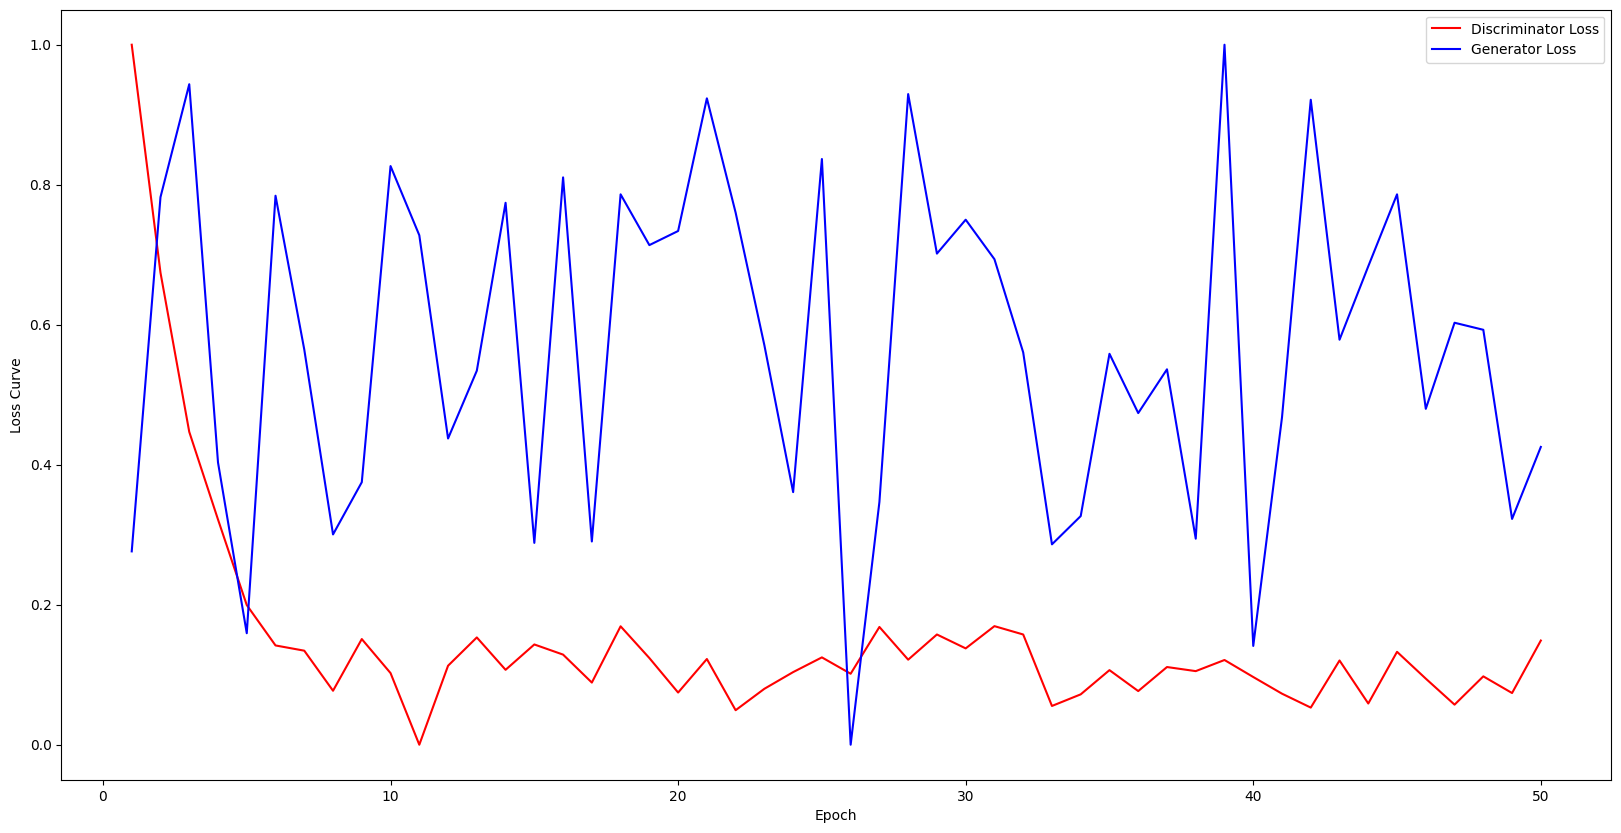

In [16]:
plot_loss_curve(g_losses, d_losses, epochs)

## generate fake samples


In [17]:
fake_labels = torch.randint(0, num_classes, (n_samples,), dtype=torch.long)
z = torch.randn((n_samples, latent_dim))

# print("random noise shape", z.shape)
# set generator to eval mode
gen.eval()

fake_data = gen(z.to(device), fake_labels.to(device)).detach().cpu()

# print the generated data: if the data contains nan values, it means that there is gradient explosion, or other issues. To avoid such problems, change the termperature value to be between 0.1 and 0.5. Also, trying changing the learning rate to be between 5e-6 and 1e-4. Of course, this is just a suggestion. You might experiment with other values if you want, and report your findings.
# print(fake_data[0])

In [18]:
# get the generated samples as tokens (this are a sequence tokens or words / characters, represented by integers .)
from pprint import pprint

fake_samples = torch.argmax(fake_data, dim=-1).cpu().numpy()

# now, let's see two generated sequences
pprint(fake_samples[:2])

array([[224, 299,  34, 118, 164,  51, 209, 301, 169, 171,  59, 107, 192,
        155, 119, 269,  98, 155, 278, 128, 170, 110, 201, 258, 142, 167,
          9,  66,  80, 116, 269,  99,  96, 337,  84,  82,  30, 120, 331,
        288, 191, 180, 279, 289, 125, 264, 314,  60, 229, 271, 252, 308,
         98, 243, 107, 268, 113, 114, 244, 164,  44, 161, 271, 304, 296,
         44, 144, 232, 319, 297,  49,   7, 172, 282, 242, 132, 180, 149,
          0, 187, 119, 213, 276, 262, 220,  38, 246,  68, 300,  56,  58,
        274, 341, 222, 102, 115,  95, 141, 313, 315],
       [307,  15,  14, 311,  53,   6, 128,  91, 226, 221, 151,  77, 113,
         12,  24, 214,  59, 308, 290, 336, 137,  96,  25,  60, 209, 220,
         90, 341, 268,  16, 302, 107, 294, 146, 299, 271, 113, 194, 238,
        200, 339, 255, 306,  76,  91, 301, 297, 164, 308,  62,  17, 292,
         90,  34, 284, 139,  24,   3, 290,  52, 327, 242,  98, 243,  82,
        261, 221, 164, 305, 314, 113, 317, 147, 186,  39, 178,  57, 20

# Now, we can generate from generated tokens (i.e., sequence)

` To do so, we can use the sequence_to_graph() function given in the preprocess_data.py`


In [19]:
# convert the generated samples into a networkx graph and also pytorch_geometric graph data object
networkx_graph, pytorch_geometric_data = sequence_to_graph(fake_samples[0])

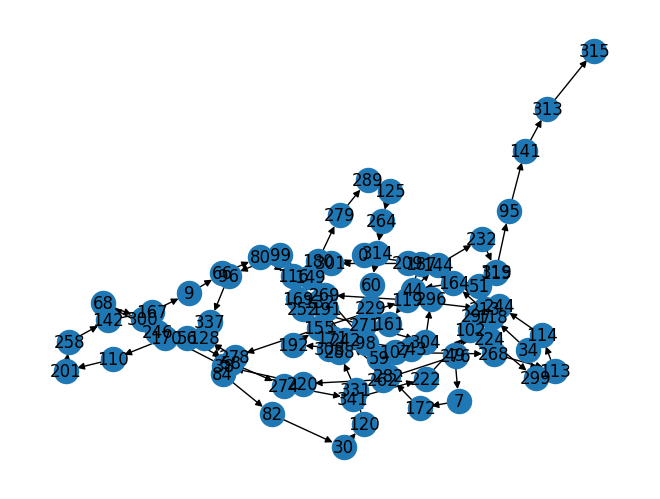

In [20]:
# you can see the networkx graph we generated
nx.draw(networkx_graph, with_labels=True)
plt.show()

# The Remaining Steps:

```
1 - generate many fake samples (sequences and their labels),

2 - add these fake sequences to train_data sequences, and add their fake_labels (benign or malign) to the trian_labels

3 - train GCNModel again and compare performance before and after adding fake samples.


```
